In [1]:
import numpy as np
import cv2 as cv
from cake import cake
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import image
from matplotlib import cm
import scienceplots
import os
import matplotlib.patches as mpatches
from IPython.display import HTML
from IPython.display import Video
from celluloid import Camera

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)


# Input Data

In [2]:
folder_name="Gute_aufnahme_shortened"
destination_video_name="sorted_trajectory_superimposed.avi"

In [3]:
os.makedirs(os.path.join("Video_Data",folder_name),exist_ok=True)
data_paths=os.listdir(os.path.join("data",folder_name))
stream_string=np.load(os.path.join("data",folder_name,"image_paths.npy"))
objs=[x for x in data_paths if "pos_data" in x]
objs_number=np.array([int(x[9:-4]) for x in objs])
indexing=np.argsort(objs_number)
objs=[np.load(os.path.join("data",folder_name,objs[x])) for x in indexing]
number_objs=len(objs)

In [4]:
# Comment this cell out if you want all trajectories
length_of_objs=np.array([np.sum(np.linalg.norm(np.diff(x[:,1:3],axis=0),axis=1)) for x in objs])
sorted_objs_index=np.argsort(length_of_objs)[::-1]
objs_sorted=[objs[i] for i in sorted_objs_index]
objs=[objs_sorted[i] for i in range(5)]
number_objs=len(objs)

In [5]:
print(sorted_objs_index)

[16 15 17 14 18  9  8  7 10 13  1  0  2  3  4  6 11  5 12]


# Plot trajectory and animate

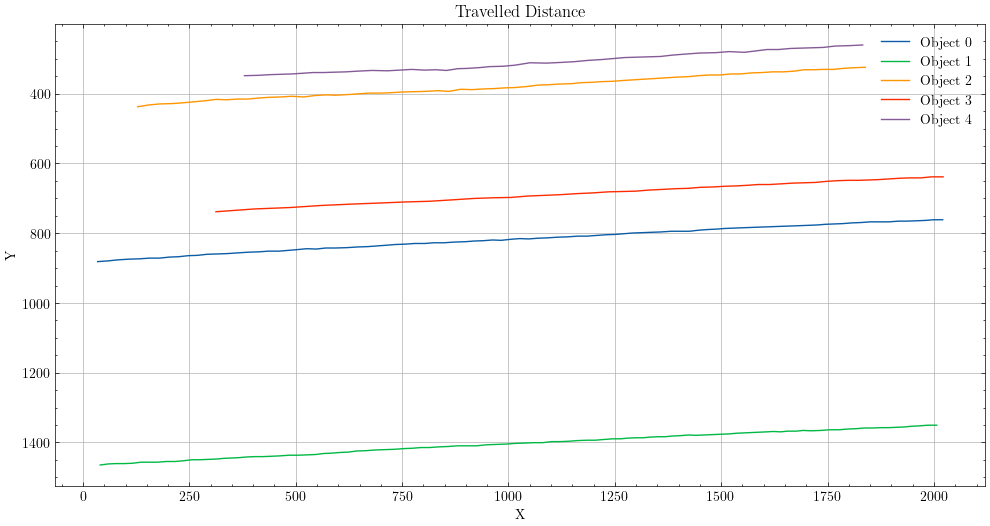

In [6]:
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12,6]
    plt.xlabel("X")
    plt.ylabel("Y")
    for i in range(number_objs):
        plt.plot(objs[i][:,1],objs[i][:,2],label="Object "+str(i))
    plt.grid()
    plt.title("Travelled Distance")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()


In [7]:
cmap = plt.get_cmap('tab20b')  # Choose your colormap here
norm = mpl.colors.Normalize(vmin=0, vmax=number_objs)
scalarMap = cm.ScalarMappable(norm=norm, cmap=cmap)
clrs=scalarMap.to_rgba(np.arange(number_objs))


In [8]:
src=cv.imread(stream_string[0], cv.IMREAD_GRAYSCALE)
start_frames=[int(x[0,0]) for x in objs]
end_frames=[int(x[-1,0]) for x in objs]

fig, ax = plt.subplots()
ax.set(xlim=(0, src.shape[1]), ylim=(0, src.shape[0]))
plt.gca().invert_yaxis()
ax.set_ylabel('y', fontsize=15)
ax.set_xlabel('x', fontsize=15)
ax.grid()
# Initiate camera
camera = Camera(fig)
patches=[]
for i in range(number_objs):
    patches.append(mpatches.Patch(color=clrs[i], label='object '+str(i)))
fig.legend(handles=patches,frameon=True, facecolor="orange")

# Create individual frames#
for j in range(1,stream_string.size):
    for i in range(number_objs):
    # Projectile's trajectory
        traj=objs[i][:,1:3]
        if j>start_frames[i] and j<=end_frames[i]:
            x = traj[0:j-start_frames[i],0]
            y = traj[0:j-start_frames[i],1]
        elif j>end_frames[i]:
            x = traj[:,0]
            y = traj[:,1]
        else:
            x = np.zeros(1)
            y = np.zeros(1)
        ax.plot(x, y, lw=2,color=clrs[i])
    # Capture frame
    camera.snap()

# Stop the static plot from displaying
plt.close()

In [9]:
# Create animation
anim = camera.animate(interval = 40, repeat = True, repeat_delay = 500)

# Inline display
HTML(anim.to_html5_video())

# Make Video of trajectory and Original Video superimposed

In [10]:
# set frames per second
fps=15
# set annotation
annotate=True


video = cv.VideoWriter(os.path.join("Video_Data",folder_name,destination_video_name), 0, fps, (src.shape[1],src.shape[0]) ,isColor=True)
# for writing on image
font = cv.FONT_HERSHEY_SIMPLEX
org = (20, 25)
fontScale = 1
color = (255, 0, 0)
thickness = 1
k=0
max_frame=np.array([x[-1,0] for x in objs])
max_k=max_frame-1
max_frame=int(np.max(max_frame))

for current_frame_number in range(max_frame):
    image_current=cv.imread(stream_string[current_frame_number])
    for j in range(number_objs):
        traj=objs[j][:,1:3]
        if start_frames[j]>current_frame_number:
            continue
        # mark beginning point with green
        image_current=cv.circle(image_current, (round(traj[0,0]),round(traj[0,1])), radius=5, color=(0, 255, 255), thickness=-1)
        for i in range(start_frames[j],min(k,int(max_k[j]))):
            start_point = (round(traj[i-start_frames[j],0]), round(traj[i-start_frames[j],1]))
            end_point = (round(traj[i+1-start_frames[j],0]), round(traj[i+1-start_frames[j],1]))
            color=(clrs[j][-2::-1]*255)
            thickness = 2
            image_current = cv.line(image_current, start_point, end_point, color, thickness)
    k=k+1
    video.write(image_current)
video.write(image_current)
cv.destroyAllWindows()
video.release()